In [1]:
import torch
import torchvision
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from ntbk.guided_diffusion.unet import create_model
from src.utils import *
from src.h_fcn import *
from src.pigdm import PIGDM
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda:0


In [2]:
# Load model
model_config = {'image_size': 256,
                'num_channels': 128,
                'num_res_blocks': 1,
                'channel_mult': '',
                'learn_sigma': True,
                'class_cond': False,
                'use_checkpoint': False,
                'attention_resolutions': 16,
                'num_heads': 4,
                'num_head_channels': 64,
                'num_heads_upsample': -1,
                'use_scale_shift_norm': True,
                'dropout': 0.0,
                'resblock_updown': True,
                'use_fp16': False,
                'use_new_attention_order': False,
                'model_path': '../ntbk/ffhq_10m.pt'}
model = create_model(**model_config)
model = model.to(device)
# use in eval mode:
model.eval();


In [5]:
imgshape = (1, 3, 256, 256)
idx = 12 
img_pil = Image.open('../data/ffhq256-1k-validation/'+str(idx).zfill(5)+'.png')
x_true = pilimg_to_tensor(img_pil)

mask = torch.ones(imgshape, device=device)
h, w = 256, 256
hcrop, wcrop = h // 4, w // 4
corner_top, corner_left = int(h // 1.7) - hcrop // 1, w // 2 #- wcrop // 1
mask[:, :, corner_top:corner_top + hcrop, corner_left:corner_left + wcrop] = 0

H = Inpainting(mask)
y = H(x_true)

  0%|          | 0/1000 [00:00<?, ?it/s]/home/onyxia/work/Generative_Modeling_Project/src/pigdm.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha_s = torch.tensor(self.alphas_cp_torch[si].cpu() if si != -1 else 1.0, device=self.device, dtype=torch.float32).view(-1, 1, 1, 1)


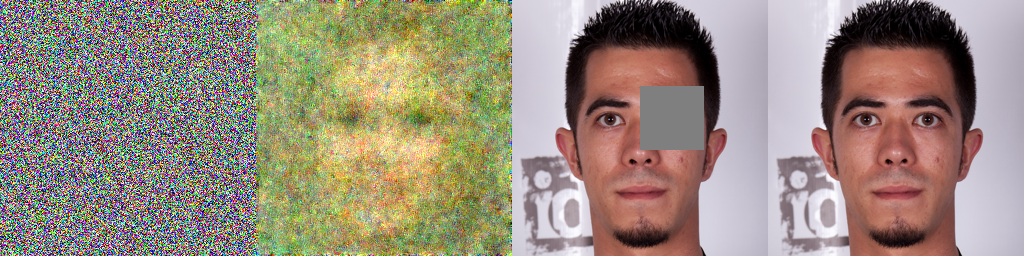

 20%|██        | 200/1000 [00:46<03:03,  4.35it/s]

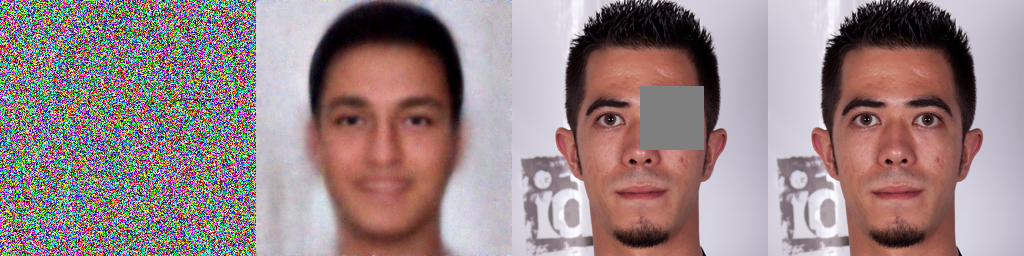

 40%|████      | 400/1000 [01:32<02:18,  4.34it/s]

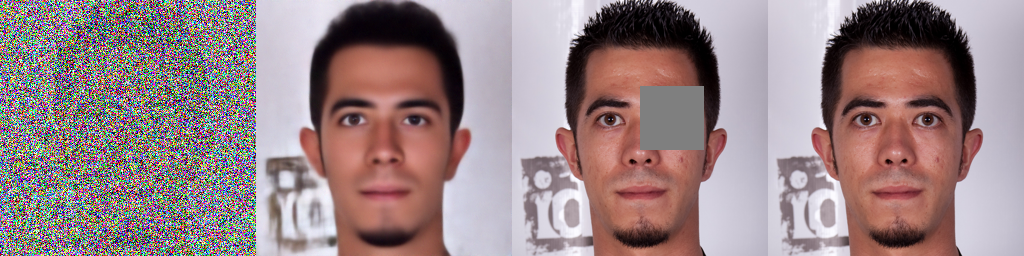

 60%|██████    | 600/1000 [02:19<01:32,  4.31it/s]

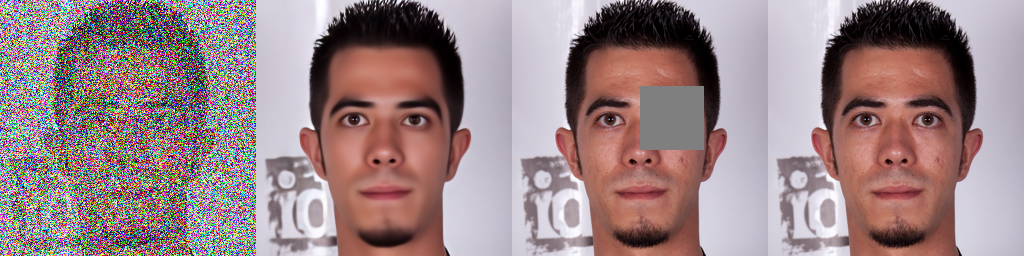

 80%|████████  | 800/1000 [03:05<00:46,  4.31it/s]

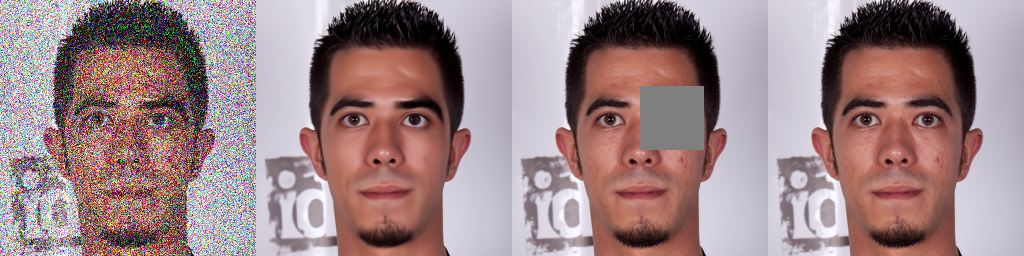

100%|█████████▉| 999/1000 [03:51<00:00,  4.31it/s]


In [4]:
pgm = PIGDM(model, 256, H)

_ = pgm.posterior_sampling(None, y.repeat(1, 1, 1, 1), x_true=x_true)

High res

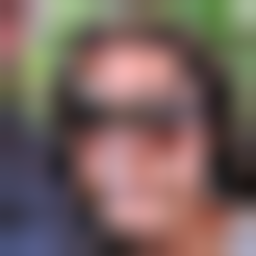

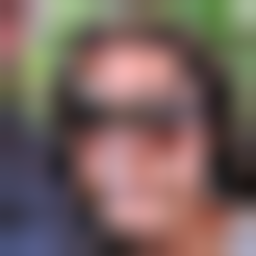

In [8]:
display_as_pilimg(H.show(y))

  0%|          | 0/1000 [00:00<?, ?it/s]/home/onyxia/work/Generative_Modeling_Project/src/pigdm.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha_s = torch.tensor(self.alphas_cp_torch[si].cpu() if si != -1 else 1.0, device=self.device, dtype=torch.float32).view(-1, 1, 1, 1)


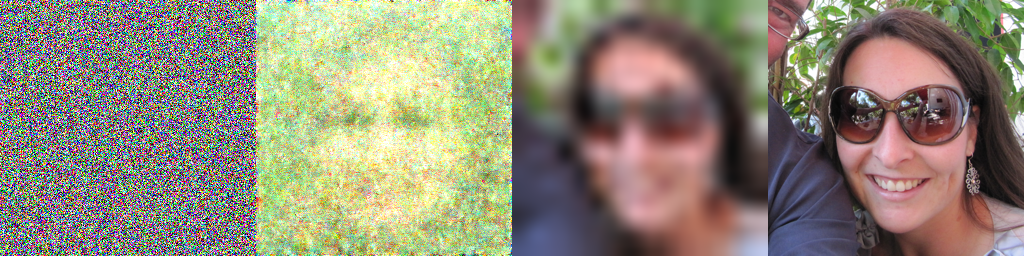

 20%|██        | 200/1000 [00:46<03:04,  4.34it/s]

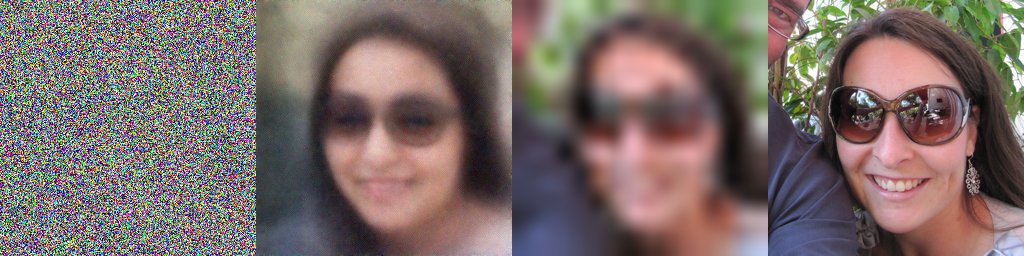

 40%|████      | 400/1000 [01:32<02:18,  4.34it/s]

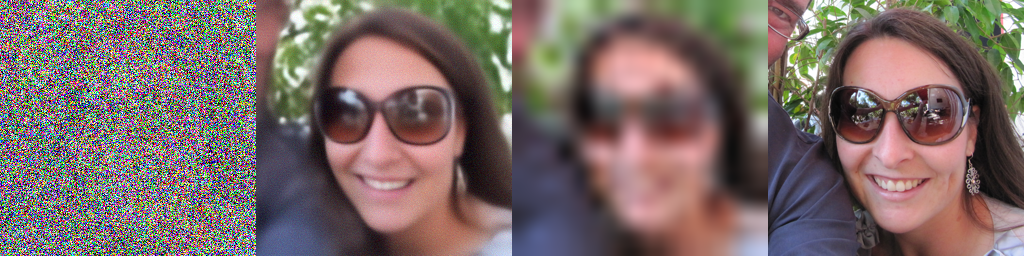

 60%|██████    | 600/1000 [02:18<01:32,  4.34it/s]

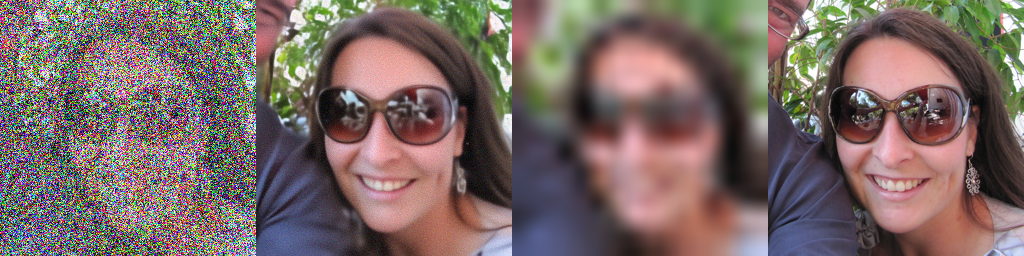

 80%|████████  | 800/1000 [03:04<00:46,  4.35it/s]

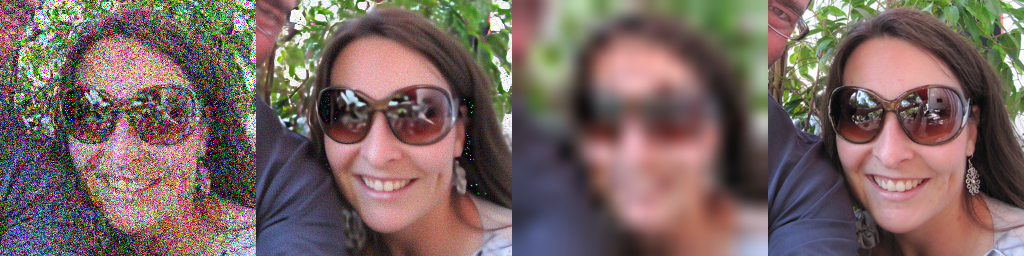

100%|█████████▉| 999/1000 [03:50<00:00,  4.33it/s]


In [10]:

idx = 22
x_true_pil = Image.open('../data/ffhq256-1k-validation/'+str(idx).zfill(5)+'.png')
x_true = pilimg_to_tensor(x_true_pil)

scale = 4
H = Superres(scale)
y = H(x_true)

pgm = PIGDM(model, 256, H)

_ = pgm.posterior_sampling(None, y.repeat(1, 1, 1, 1), x_true=x_true, steps_viz=200)

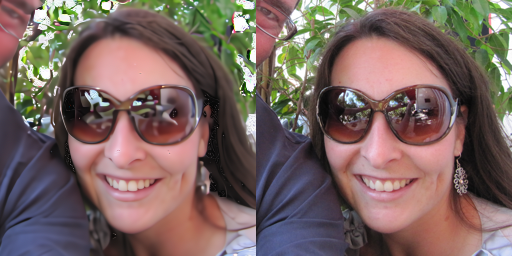

In [17]:
_ = display_as_pilimg(torch.cat((_[0][0], x_true.cpu()), dim=3))